In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gamma
from scipy.linalg import sqrtm
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

# Корзина опционов

Пример (Krekel, 2004). В рамках модели Блэка-Шоулза вычислите цены опциона колл на корзину с четырьмя акциями, для которых $T = 5~лет$, безрисковая ставка $r = 0$, корреляция $\rho_{ij} = 0,5$, $\forall i \neq j$, $K = 100$, $F^T_i = 100$, $σ_i = 40\%$ и $w_i = 0,25, i, j = 1, 2, 3, 4$.

Используйте аппроксимацию различными методами
* метод условного математического ожидания (Beisser),
* аппроксимация геометрическим средним (Gentel),
* метод моментов (Levy),
* **метод Джу через разложения в ряд Тейлора** (Ju),
* аппроксимация через обратное геометрическое распределение (MP-RG),
* **метод моментов высших порядков** (MP-4M)

и
сравните полученные аппроксимации с методом Монте-Карло.

In [2]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4

In [3]:
rho

array([[1. , 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Аппроксимация геометрическим средним (Gentel)

In [4]:
# аппроксимация корзины опционов геометрическим средним
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  a = w * F / np.sum(w * F)

  m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
  v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)

  K_star =  K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)

  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
  d2 = d1 - v_tilde

  basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))

  return basket_call

In [5]:
geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)

np.float64(23.783632811454414)

## Метод условного математического ожидания (Beisser)

In [6]:
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(0, len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma):
  basket_call = 0
  a = S * w * sigma
  sigmaz = np.sqrt(a.T @ rho @ a)
  sqrt_T = np.sqrt(T)

  z_star = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho)).x[0]
  for i in range(0, len(w)):
    m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
    sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
    K_star = S[i] * np.exp(sigma[i] * m * z_star - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
    S_star = S[i] * np.exp((r - q[i] - 1/2 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
    d1 = (np.log(S[i] / K_star) + (r - q[i] + 1/2 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2 = d1 - sigma_star * np.sqrt(T)
    basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

In [7]:
Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)

np.float64(6.908159755754296)

## Задача

### Метод Джу через разложения в ряд Тейлора (Ju)

Статья [(Ju, 2002)](https://drive.google.com/file/d/1JJuZhRiCUGf6euyfju1Dn5aRP46-3iry/view?usp=drive_link)

In [8]:
def ju_taylor_approximation_call(S, K, T, sigma, w, rho, r=0):
    """
    Ju's Taylor approximation for option pricing with correlated assets.
    
    Parameters:
    - S: np.ndarray, asset prices.
    - K: float, strike price.
    - T: float, time to maturity.
    - sigma: float, volatility of the assets.
    - w: np.ndarray, portfolio weights for each asset.
    - rho: np.ndarray, correlation matrix of the assets.
    - r: float, risk-free rate (default is 0).
    
    Returns:
    - BC: float, option price approximation.
    """
    N = len(S)
    sigma_matrix = sigma**2 * T * np.ones_like(rho)
    
    # Compute U1
    U1 = np.sum(w * S)
    
    # Compute U2_0
    U2_0_diag = np.sum((w * S * np.exp(r * T))**2)
    U2_0_offdiag = np.sum([
        w[i] * S[i] * w[j] * S[j] * np.exp(sigma_matrix[i, j] * np.exp(2 * r * T)) 
        for i in range(N) for j in range(N) if i != j
    ])
    U2_0 = U2_0_diag + U2_0_offdiag
    
    # Compute derivatives of U2
    U2_der_1 = np.sum([
        w[i] * S[i] * w[j] * S[j] * sigma_matrix[i, j] * rho[i, j]
        for i in range(N) for j in range(N)
    ])
    U2_der_2 = np.sum([
        w[i] * S[i] * w[j] * S[j] * (sigma_matrix[i, j] * rho[i, j]**2)
        for i in range(N) for j in range(N)
    ])
    U2_der_3 = np.sum([
        w[i] * S[i] * w[j] * S[j] * (sigma_matrix[i, j] * rho[i, j]**3)
        for i in range(N) for j in range(N)
    ])
    
    # Compute moments
    m_0 = 2 * np.log(U1) - 0.5 * np.log(U2_0)
    nu_0 = np.log(U2_0) - 2 * np.log(U1)
    
    # Compute coefficients
    a1 = -U2_der_1 / (2 * U2_0)
    a2 = 2 * a1**2 - U2_der_2 / (2 * U2_0)
    a3 = 6 * a1 * a2 - 4 * a1**3 - U2_der_3 / (2 * U2_0)
    
    # Compute z coefficients
    z1 = a2 - a3
    z2 = a3
    z3 = 0  # As per the provided code
    
    # Compute y thresholds
    y1 = (m_0 - np.log(K)) / np.sqrt(nu_0) + np.sqrt(nu_0)
    y2 = y1 - np.sqrt(nu_0)
    
    # Probability density and derivatives
    p_y = lambda x: (1 / np.sqrt(2 * np.pi * nu_0)) * np.exp(-(x - m_0)**2 / (2 * nu_0))
    dp_y = lambda x: -p_y(x) * (x - m_0) / nu_0
    d2p_y = lambda x: p_y(x) * ((x - m_0) / nu_0)**2 - p_y(x) / nu_0
    
    # Compute option price approximation
    BC = (U1 * norm.cdf(y1) - K * norm.cdf(y2) +
          K * (z1 * p_y(np.log(K)) + z2 * dp_y(np.log(K)) + z3 * d2p_y(np.log(K))))
    
    return BC

In [9]:
# Расчет методом Джу
price_ju = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
print(f"Цена опциона методом Джу: {price_ju:.2f}")

Цена опциона методом Джу: 29.98


## Метод моментов (Log-normal moment matching, Levy’s matching)

In [10]:
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  m = 2 * np.log(M) - 1/2 * np.log(V2)
  v = np.sqrt(np.log(V2) - 2 * np.log(M))
  d1 = (m - np.log(K) + v**2) / v
  d2 = d1 - v
  basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
  return basket_call

In [11]:
Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)

np.float64(28.051966214249894)

## Аппроксимация через обратное геометрическое распределение (MP-RG)

In [12]:
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  alpha = (2 * V2  - M**2) / (V2 - M**2)
  beta = (V2 - M**2) / (V2 * M)
  g1 = gamma.cdf(1/K, a = alpha - 1, scale = beta)
  g2 = gamma.cdf(1/K, a = alpha, scale = beta)
  basket_call = np.exp(-r * T) * (M * g1 - K * g2)
  return basket_call

In [13]:
Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)

np.float64(24.495775089623557)

## Задача

### Метод моментов высоких порядков (MP-4M)

Статья [(Posner and Milevsky, 1998)](https://https://drive.google.com/file/d/16f5dRiA_HD9jhm-esUT_6gGoArk9Nc2u/view?usp=drive_link)

In [14]:
n_scenarios = 10000

def basket_moments(S0, weights, sigma, r, rho, T):
    F = S0 * np.exp(r * T)
    mean = np.sum(weights * F)
    
    var = 0
    for i in range(0, len(weights)):
        for j in range(0, len(weights)):
            var += weights[i] * weights[j] * F[i] * F[j] * (np.exp(sigma[i] * sigma[j] * rho[i][j] * T)-1)
    
    std_dev = np.sqrt(var)
    
    skewness = 0 # np.mean(np.exp(sigma**2 * T) + 2)
    kurtosis = np.exp(sigma[0]**2 * T) + np.exp(2*sigma[0]**2 * T)
    
    return mean, std_dev, skewness, kurtosis

mean, std_dev, skewness, kurtosis = basket_moments(S, w, sigma, r, rho, T)

# Generate scenarios for the basket
def generate_basket_scenarios(mean, std_dev, skewness, kurtosis, n_scenarios):
    Z = np.random.normal(0, 1, n_scenarios)
    basket_values = mean + std_dev * (
        Z + 
        (skewness / 6) * (Z**2 - 1) + 
        (kurtosis - 3) / 24 * (Z**3 - 3 * Z)
    )
    return basket_values

basket_scenarios = generate_basket_scenarios(mean, std_dev, skewness, kurtosis, n_scenarios)

# Define the payoff function for a basket call option
def payoff_function(basket, K):
    return np.maximum(basket - K, 0)

payoffs = payoff_function(basket_scenarios, K)
basket_option_price = np.exp(-r * T) * np.mean(payoffs)

# Output the result
print(f"Basket Call Option Price: {basket_option_price:.2f}")

Basket Call Option Price: 27.48


In [15]:
def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma, N=1000):
# ваш код
  mean, std_dev, skewness, kurtosis = basket_moments(S, w, sigma, r, rho, T)
  basket_scenarios = generate_basket_scenarios(mean, std_dev, skewness, kurtosis, n_scenarios)
  payoffs = payoff_function(basket_scenarios, K)
  basket_call = np.exp(-r * T) * np.mean(payoffs)

  return basket_call
# ответ = 27.98
Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

np.float64(26.725855968308025)

In [17]:
# ответ = 27.98

## Метод Монте-Карло

In [18]:
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  basket_call = np.mean(np.maximum(B_T - K, 0)) * np.exp(-r * T)
  return basket_call

In [19]:
N_mc = int(10**6)
MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

np.float64(28.096064004911817)

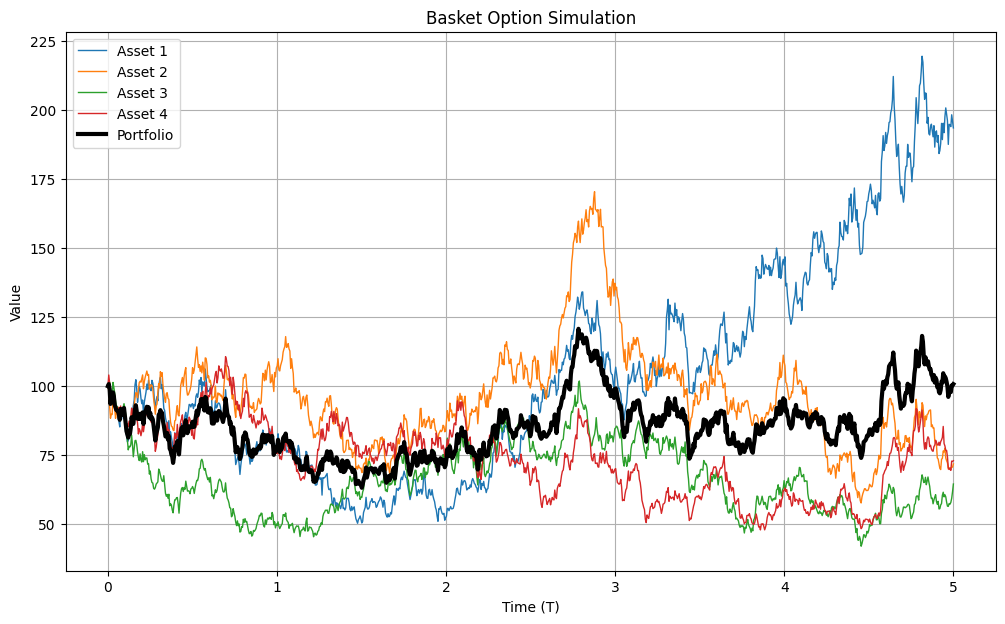

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_basket_paths(F, T, r, sigma, rho, w, n_steps=1000):
    """
    Simulates the price paths of assets in a basket option using Monte Carlo.

    Parameters:
        F (ndarray): Initial prices of the assets (shape: (n_assets,)).
        T (float): Time to maturity in years.
        r (float): Risk-free rate.
        sigma (ndarray): Volatilities of the assets (shape: (n_assets,)).
        rho (ndarray): Correlation matrix (shape: (n_assets, n_assets)).
        w (ndarray): Weights of the assets in the basket (shape: (n_assets,)).
        n_steps (int): Number of simulation steps.

    Returns:
        t_grid (ndarray): Time points of the simulation (shape: (n_steps,)).
        asset_paths (ndarray): Simulated paths of asset prices (shape: (n_steps, n_assets)).
        portfolio_values (ndarray): Simulated portfolio values (shape: (n_steps,)).
    """
    n_assets = len(F)
    dt = T / n_steps  # Time step size
    cov_matrix = np.outer(sigma, sigma) * rho  # Covariance matrix for Brownian motion

    # Initialize asset price paths
    asset_paths = np.zeros((n_steps, n_assets))
    asset_paths[0] = F

    # Simulate paths
    for t in range(1, n_steps):
        dW = np.random.multivariate_normal(np.zeros(n_assets), cov_matrix) * np.sqrt(dt)
        drift = r * asset_paths[t - 1] * dt
        diffusion = asset_paths[t - 1] * dW
        asset_paths[t] = asset_paths[t - 1] + drift + diffusion

    # Calculate portfolio values as weighted sum of assets
    portfolio_values = asset_paths @ w
    t_grid = np.linspace(0, T, n_steps)

    return t_grid, asset_paths, portfolio_values


def plot_simulation(t_grid, asset_paths, portfolio_values):
    """
    Plots the simulated paths of assets and the portfolio value.

    Parameters:
        t_grid (ndarray): Time points of the simulation.
        asset_paths (ndarray): Simulated paths of asset prices.
        portfolio_values (ndarray): Simulated portfolio values.
    """
    plt.figure(figsize=(12, 7))
    n_assets = asset_paths.shape[1]

    # Plot individual asset paths
    for i in range(n_assets):
        plt.plot(t_grid, asset_paths[:, i], lw=1, label=f'Asset {i + 1}')

    # Plot portfolio value
    plt.plot(t_grid, portfolio_values, lw=3, color='black', label='Portfolio')

    # Add labels and legend
    plt.xlabel('Time (T)')
    plt.ylabel('Value')
    plt.title('Basket Option Simulation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run simulation
t_grid, asset_paths, portfolio_values = simulate_basket_paths(F, T, r, sigma, rho, w)

# Plot results
plot_simulation(t_grid, asset_paths, portfolio_values)


In [21]:
import numpy as np
from tqdm import tqdm

def monte_carlo_pricing(F, K, T, r, sigma, rho, w, n_sims=10**4, n_steps=5000):
    """
    Monte Carlo simulation for pricing European call and put options on a basket.

    Parameters:
        F (ndarray): Initial prices of the assets (shape: (n_assets,)).
        K (float): Strike price of the options.
        T (float): Time to maturity in years.
        r (float): Risk-free rate.
        sigma (ndarray): Volatilities of the assets (shape: (n_assets,)).
        rho (ndarray): Correlation matrix (shape: (n_assets, n_assets)).
        w (ndarray): Weights of the assets in the basket (shape: (n_assets,)).
        n_sims (int): Number of Monte Carlo simulations.
        n_steps (int): Number of time steps.

    Returns:
        call_price (float): Estimated call option price.
        put_price (float): Estimated put option price.
    """
    n_assets = len(F)
    dt = T / n_steps  # Time step size
    cov_matrix = np.outer(sigma, sigma) * rho  # Covariance matrix for Brownian motion

    # Initialize asset prices
    S = np.zeros((n_sims, n_assets))
    S[...] = F  # Broadcast initial prices across simulations

    # Simulate asset price paths
    for _ in tqdm(range(n_steps), desc="Simulating paths"):
        dW = np.random.multivariate_normal(np.zeros(n_assets), cov_matrix, size=n_sims) * np.sqrt(dt)
        drift = r * S * dt
        diffusion = S * dW
        S += drift + diffusion

    # Calculate portfolio values at maturity
    portfolio_values = S @ w

    # Calculate option payoffs
    call_payoffs = np.maximum(portfolio_values - K, 0)
    put_payoffs = np.maximum(K - portfolio_values, 0)

    # Discounted mean payoff
    discount_factor = np.exp(-r * T)
    call_price = discount_factor * np.mean(call_payoffs)
    put_price = discount_factor * np.mean(put_payoffs)

    return call_price, put_price

In [22]:
# Run Monte Carlo simulation
call_price_mc, put_price_mc = monte_carlo_pricing(F, K, T, r, sigma, rho, w)

# Display results
print(f"Call price by Monte Carlo: {call_price_mc:.4f}")
print(f"Put price by Monte Carlo: {put_price_mc:.4f}")

Simulating paths:   0%|          | 0/5000 [00:00<?, ?it/s]

Simulating paths: 100%|██████████| 5000/5000 [00:03<00:00, 1354.52it/s]

Call price by Monte Carlo: 28.9135
Put price by Monte Carlo: 28.4177


Пример. Для метода Монте-Карло реализуйте функцию для вычисления стандартного отклонения
$
StdDev = \sqrt{\frac{1}{n}\sum_{i=1}^n(Price - MC\,Price)^2}
$
и постройте доверительный интервал для оценки.

In [23]:
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w) 
    COV = sigma[:, None] * rho * sigma[None, :]
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
    B_T = np.zeros(N_mc)  

    for k in range(n):
        B_T += S[k] * np.exp((r - q[k] - 0.5 * sigma[k] ** 2) * T + W[:, k]) * w[k]

    payoff = np.maximum(B_T - K, 0)
    mean = np.mean(payoff) * np.exp(-r * T)
    std = np.std(payoff) * np.exp(-r * T)
    return mean, std  

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # lower bound of confidence interval for the price
    hi = price + norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # upper bound of confidence interval for the price
    print(f"mean call basket price = {price}, ci: {lo} < price < {hi} with 95% prob")

In [24]:
MC_call, MC_std = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(MC_call, MC_std, N_mc)

mean call basket price = 28.06192358802827, ci: 27.931638117782462 < price < 28.19220905827408 with 95% prob


### Задача

In [25]:
# Постройте гистограммы распределения МС оценок для опионов кол и пут,
# на графики нанесите границы доверительного интервала, среднее значение (вертикальные линии),
# выдвините гипотезу о законе распределения оценок и проверьте ее статистически.
# ваш код

In [26]:
import scipy.stats as stats

def calculate_ci(data, confidence=0.95):
    """Calculate confidence interval for the given data."""
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    margin = stats.norm.ppf(0.5 + confidence / 2) * std_err
    return mean, mean - margin, mean + margin

def plot_histogram(data, mean, ci_low, ci_high, title, xlabel, ylabel):
    """Plot histogram with mean and confidence intervals."""
    plt.hist(data, bins=20, alpha=0.7, color='blue')
    plt.axvline(mean, color='black', linestyle='--', label='Mean')
    plt.axvline(ci_low, color='red', linestyle='--', label='95% CI Boundaries')
    plt.axvline(ci_high, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

def monte_carlo_pricing(F, K, T, r, sigma, rho, w, n_sims=10**4, n_steps=5000):
    """Monte Carlo simulation for pricing European call and put options on a basket."""
    n_assets = len(F)
    dt = T / n_steps  # Time step size
    cov_matrix = np.outer(sigma, sigma) * rho  # Covariance matrix for Brownian motion

    # Initialize asset prices
    S = np.zeros((n_sims, n_assets))
    S[...] = F  # Broadcast initial prices across simulations

    # Simulate asset price paths
    for _ in tqdm(range(n_steps), desc="Simulating paths"):
        dW = np.random.multivariate_normal(np.zeros(n_assets), cov_matrix, size=n_sims) * np.sqrt(dt)
        drift = r * S * dt
        diffusion = S * dW
        S += drift + diffusion

    # Calculate portfolio values at maturity
    portfolio_values = S @ w

    # Calculate option payoffs
    call_payoffs = np.maximum(portfolio_values - K, 0)
    put_payoffs = np.maximum(K - portfolio_values, 0)

    # Discounted mean payoff
    discount_factor = np.exp(-r * T)
    call_price = discount_factor * np.mean(call_payoffs)
    put_price = discount_factor * np.mean(put_payoffs)

    return call_price, put_price

def run_monte_carlo_simulations(F, K, T, r, sigma, rho, w, n_repeats=100):
    """Run Monte Carlo simulations multiple times and collect results."""
    call_prices = []
    put_prices = []

    for _ in tqdm(range(n_repeats), desc="Repeating simulations"):
        call_price, put_price = monte_carlo_pricing(F, K, T, r, sigma, rho, w)
        call_prices.append(call_price)
        put_prices.append(put_price)

    return np.array(call_prices), np.array(put_prices)

def test_normality(data, option_type="Option"):
    """Test normality of the distribution using Shapiro-Wilk test."""
    p_value = stats.shapiro(data)[1]
    if p_value > 0.05:
        print(f"{option_type}: Data is normally distributed (p-value = {p_value:.4f})")
    else:
        print(f"{option_type}: Data is not normally distributed (p-value = {p_value:.4f})")


Repeating simulations: 100%|██████████| 100/100 [08:29<00:00,  5.10s/it]


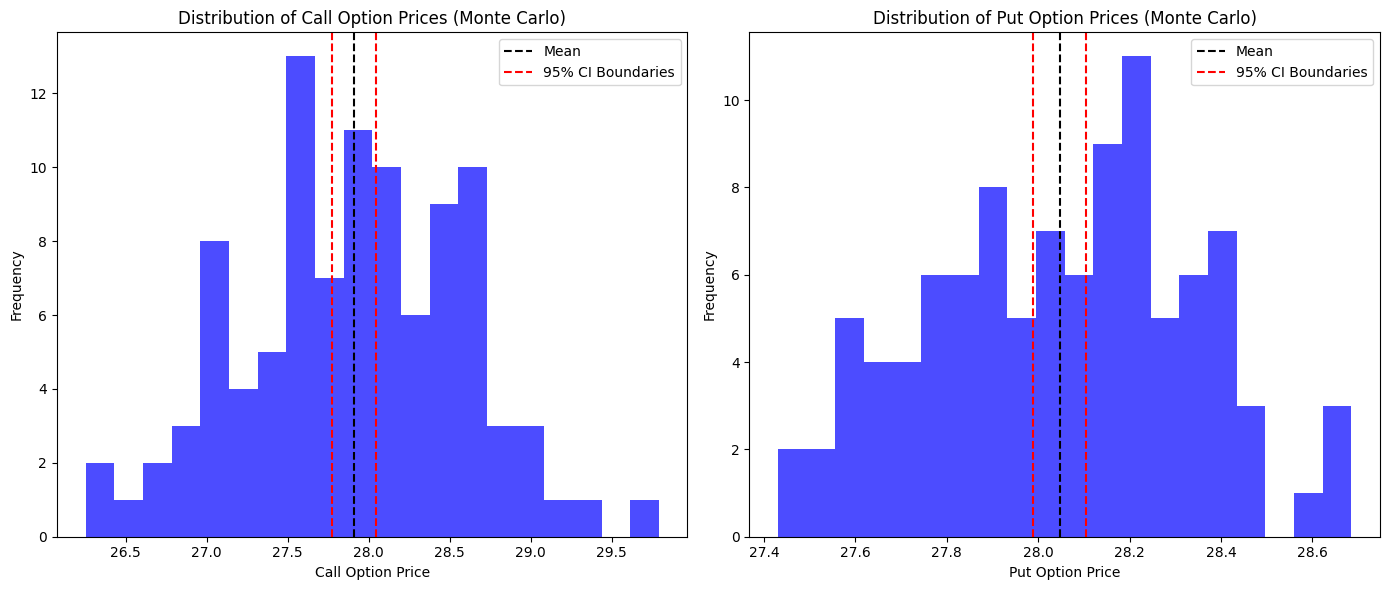

Call Prices: Data is normally distributed (p-value = 0.9121)
Put Prices: Data is normally distributed (p-value = 0.4084)


In [27]:
# Run Monte Carlo simulations and collect data
call_prices, put_prices = run_monte_carlo_simulations(F, K, T, r, sigma, rho, w)

# Calculate confidence intervals
call_mean, call_ci_low, call_ci_high = calculate_ci(call_prices)
put_mean, put_ci_low, put_ci_high = calculate_ci(put_prices)

# Plot histograms for call and put options
plt.figure(figsize=(14, 6))

# Call option histogram
plt.subplot(1, 2, 1)
plot_histogram(call_prices, call_mean, call_ci_low, call_ci_high, 
               "Distribution of Call Option Prices (Monte Carlo)", "Call Option Price", "Frequency")

# Put option histogram
plt.subplot(1, 2, 2)
plot_histogram(put_prices, put_mean, put_ci_low, put_ci_high, 
               "Distribution of Put Option Prices (Monte Carlo)", "Put Option Price", "Frequency")

plt.tight_layout()
plt.show()

# Test normality of distributions
test_normality(call_prices, option_type="Call Prices")
test_normality(put_prices, option_type="Put Prices")

## Исследование влияния параметров модели на оценку стоимости корзины опцинов

Пример.
Проведите исследование влияния параметров (варьировать один параметр, остальные -- зафиксировать) для различных методов аппроксимации и постройте графики, на которых отобразите зависимость для следующих значений параметров:  

* цена страйк $K=\{50, 60, \ldots, 150\}$,
* форвардная цена $F^T=\{50, 60, \ldots, 150\}$,
* корреляция  $\rho=\{0.1, 0.2, \ldots, 0.9, 0.95\}$,
* волатильность $\sigma=\{0.1, 0.2, \ldots, 0.9, 1.0\}$,
* веса $w_1 = \{0.5, 0.2, 0.2, 0.1\}$, $w_2 = \{0.7, 0.1, 0.1, 0.1\}$,
* безрисковая ставка $r=\{0.01, 0.02, 0.05, 0.1\}$.


### Задача.

In [28]:
# На графики добавить кривые, полученные для методов Ju и MP-4M,
# ваш код допишите в ячейке ниже

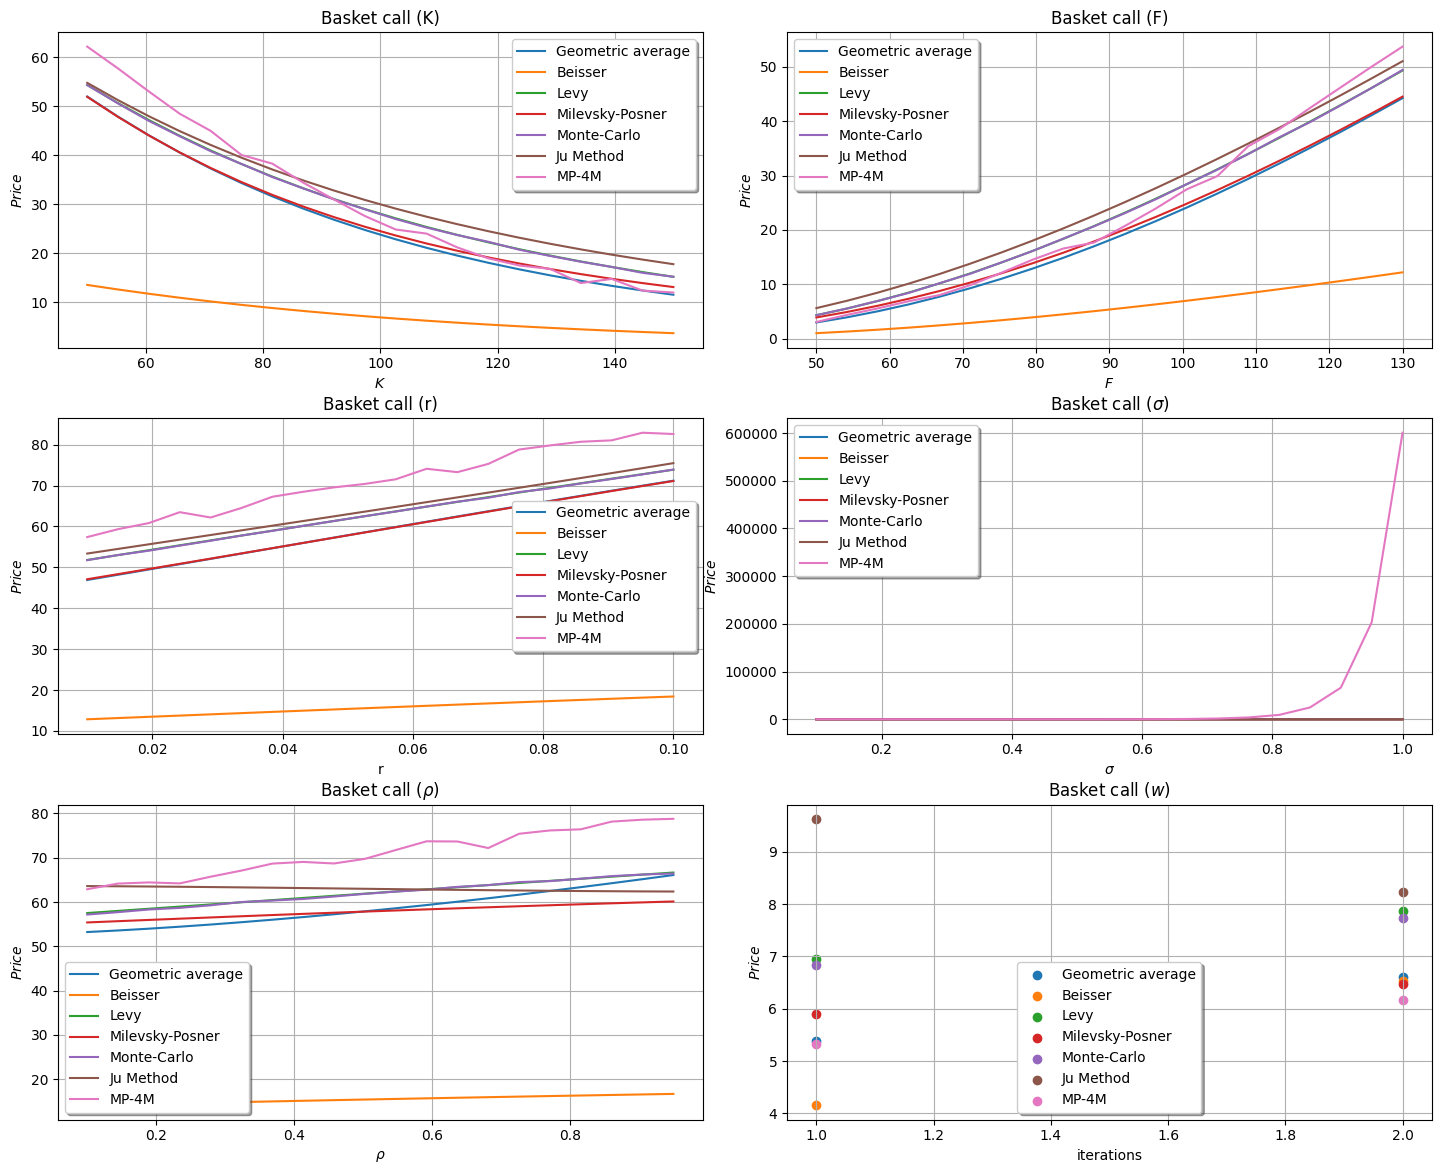

In [29]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 12))
fig.tight_layout(pad=3.0)


'''K research'''
iters = 20
K_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    geom_avg[i] = geometric_average_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K_data[i], T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K_data[i], T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K_data[i], T, sigma, w, rho, r)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)


axs[0][0].plot(K_data, geom_avg, label = 'Geometric average')
axs[0][0].plot(K_data, Beisser, label = 'Beisser')
axs[0][0].plot(K_data, Levy, label = 'Levy')
axs[0][0].plot(K_data, MP, label = 'Milevsky-Posner')
axs[0][0].plot(K_data, MC, label = r'Monte-Carlo')
axs[0][0].plot(K_data, Ju, label='Ju Method')
axs[0][0].plot(K_data, MP_4M, label='MP-4M')
axs[0][0].set_title('Basket call (K)')
axs[0][0].set_xlabel(r'$K$')
axs[0][0].set_ylabel(r'$Price$')
axs[0][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][0].grid(True)

'''F research'''
iters = 20
F_data = np.linspace(50, 130, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    S0 = F_data[i] * np.exp(-r * T)
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)


axs[0][1].plot(F_data, geom_avg, label = 'Geometric average')
axs[0][1].plot(F_data, Beisser, label = 'Beisser')
axs[0][1].plot(F_data, Levy, label = 'Levy')
axs[0][1].plot(F_data, MP, label = 'Milevsky-Posner')
axs[0][1].plot(F_data, MC, label = r'Monte-Carlo')
axs[0][1].plot(F_data, Ju, label='Ju Method')
axs[0][1].plot(F_data, MP_4M, label='MP-4M')
axs[0][1].set_title('Basket call (F)')
axs[0][1].set_xlabel(r'$F$')
axs[0][1].set_ylabel(r'$Price$')
axs[0][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][1].grid(True)


'''sigma research'''
iters = 20
S = S0 * np.ones(N)
sigma_data = np.linspace(0.1, 1.0, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    sigma = np.ones(N) * sigma_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[1][1].plot(sigma_data, geom_avg, label = 'Geometric average')
axs[1][1].plot(sigma_data, Beisser, label = 'Beisser')
axs[1][1].plot(sigma_data, Levy, label = 'Levy')
axs[1][1].plot(sigma_data, MP, label = 'Milevsky-Posner')
axs[1][1].plot(sigma_data, MC, label = r'Monte-Carlo')
axs[1][1].plot(sigma_data, Ju, label='Ju Method')
axs[1][1].plot(sigma_data, MP_4M, label='MP-4M')
axs[1][1].set_title(r'Basket call ($\sigma$)')
axs[1][1].set_xlabel(r'$\sigma$')
axs[1][1].set_ylabel(r'$Price$')
axs[1][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][1].grid(True)


'''r research'''
iters = 20
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
r_data = np.linspace(0.01, 0.1, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    r = r_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[1][0].plot(r_data, geom_avg, label = 'Geometric average')
axs[1][0].plot(r_data, Beisser, label = 'Beisser')
axs[1][0].plot(r_data, Levy, label = 'Levy')
axs[1][0].plot(r_data, MP, label = 'Milevsky-Posner')
axs[1][0].plot(r_data, MC, label = r'Monte-Carlo')
axs[1][0].plot(r_data, Ju, label='Ju Method')
axs[1][0].plot(r_data, MP_4M, label='MP-4M')
axs[1][0].set_title(r'Basket call (r)')
axs[1][0].set_xlabel(r'r')
axs[1][0].set_ylabel(r'$Price$')
axs[1][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][0].grid(True)


'''rho research'''
iters = 20
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho_data = np.linspace(0.1, 0.95, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    rho = np.ones((N,N)) * rho_data[i] + np.diag(np.ones(N)) * (1 - rho_data[i])
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[2][0].plot(rho_data, geom_avg, label = 'Geometric average')
axs[2][0].plot(rho_data, Beisser, label = 'Beisser')
axs[2][0].plot(rho_data, Levy, label = 'Levy')
axs[2][0].plot(rho_data, MP, label = 'Milevsky-Posner')
axs[2][0].plot(rho_data, MC, label = r'Monte-Carlo')
axs[2][0].plot(rho_data, Ju, label='Ju Method')
axs[2][0].plot(rho_data, MP_4M, label='MP-4M')
axs[2][0].set_title(r'Basket call ($\rho$)')
axs[2][0].set_xlabel(r'$\rho$')
axs[2][0].set_ylabel(r'$Price$')
axs[2][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][0].grid(True)


'''w research'''
iters = 2
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho = np.ones((N,N)) * 0.5 + np.diag(np.ones(N)) * (1 - 0.5)
w_data = np.array([[0.5, 0.2, 0.2, 0.1],[0.7, 0.1, 0.1, 0.1]])
S_data = np.array([[50, 40, 60, 30],[50, 40, 60, 30]])
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)
iterations = [1, 2]
for i in range(0, iters):
    S = S_data[i]
    w = w_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    

axs[2][1].scatter(iterations, geom_avg, label = 'Geometric average')
axs[2][1].scatter(iterations, Beisser, label = 'Beisser')
axs[2][1].scatter(iterations, Levy, label = 'Levy')
axs[2][1].scatter(iterations, MP, label = 'Milevsky-Posner')
axs[2][1].scatter(iterations, MC, label = r'Monte-Carlo')
axs[2][1].scatter(iterations, Ju, label='Ju Method')
axs[2][1].scatter(iterations, MP_4M, label='MP-4M')
axs[2][1].set_title(r'Basket call ($w$)')
axs[2][1].set_xlabel(r'iterations')
axs[2][1].set_ylabel(r'$Price$')
axs[2][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][1].grid(True)

In [30]:
def pdfs_comparison():
  iters = 100
  S_data = np.linspace(50, 150, iters)
  geom_avg = np.zeros(iters)
  Beisser = np.zeros(iters)
  Levy = np.zeros(iters)
  MP = np.zeros(iters)
  MC = np.zeros(iters)
  Ju = np.zeros(iters)
  MP_4M = np.zeros(iters)

  for i in range(0, iters):
    S0 = S_data[i]
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, int(10**5))
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

  plt.plot(S_data, geom_avg, label = 'Gentel')
  plt.plot(S_data, Beisser, label = 'Beisser')
  plt.plot(S_data, Levy, label = 'Levy')
  plt.plot(S_data, MP, label = 'MP-RG')
  plt.plot(S_data, MC, label = r'MC, $N=10^5$')
  plt.plot(S_data, MP_4M, label = 'MP-4M')
  plt.plot(S_data, Ju, label = 'Ju Method') 
  plt.title('Basket call')
  plt.xlabel(r'$S_0$')
  plt.legend(loc = 'best', fancybox = True, shadow = True)
  plt.grid(True)


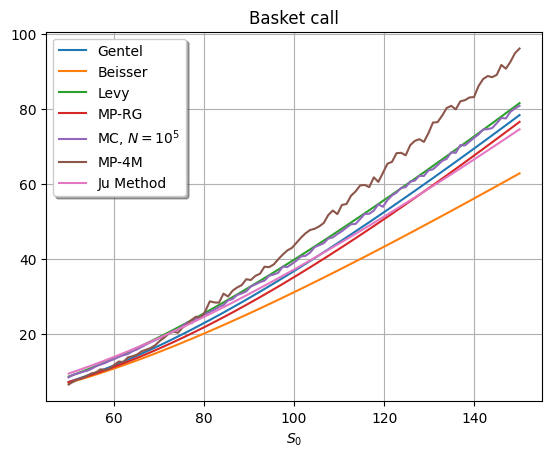

In [31]:
pdfs_comparison()

# Мини-проект (оценка корзины нейронной сетью)

Оцените корзину европейских опционов с помощью полносвязанной модели нейронной сети.

*  Сгенерируйте цены для $10 000$ опционных корзин, используя одну из аналитических аппроксимаций.
*  Обучите полностью связанную искусственную нейронную сеть для оценки стоиомости опционов.
*  Сравните полученные оценки с Монте-Карло оценками.
Приведите иллюстративные графики.


1. Корзина европейских опционов колл + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M
1. Корзина европейских опционов пут + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M

Option Pricing with Deep Learning

[Отчет](https://cs230.stanford.edu/projects_fall_2019/reports/26260984.pdf) [Постер](https://cs230.stanford.edu/projects_fall_2019/posters/26260929.pdf)
[Пример.](https://github.com/nluciw/pricing_basket_options/blob/main/main_analysis.ipynb)

In [32]:
# ваш код